In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] ='false'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] ='0.4'
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] ='platform'

# import tensorflow as tf
# tf.config.experimental.set_visible_devices([], "GPU")

import jax.numpy as jnp
from jax import random, vmap, pmap, local_devices, local_device_count
from jax.scipy.stats import multivariate_normal

import numpy as np
from jax import image
from tqdm.auto import trange

from models import VAE
from archs import MLP, periodic_encoding
from utils import restore_checkpoint

from configs.default import get_config

import matplotlib.pyplot as plt
from matplotlib import style
# style.use('dark_background')
# style.use('Solarize_Light2')

%matplotlib inline

print(local_devices())

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                      'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 20,
                      'lines.linewidth': 3,
                      'axes.labelsize': 22,  
                      'axes.titlesize': 24,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2})

In [5]:
def sample_u(rng_key, X, n):
    k1, k2 = random.split(rng_key)
    mu = random.uniform(k1, (2,), minval=0.0, maxval=1.0)
    sigma = random.uniform(k2, (1,), minval=0.0, maxval=0.01) + 0.001
    u = multivariate_normal.pdf(X, mu, sigma*jnp.eye(2))
    w = 1.0/jnp.linalg.norm(u, 2)**2
    return u.reshape(n,n).T[...,jnp.newaxis], X, u[:,None], jnp.tile(w, (X.shape[0],1))

N = 2048
m = 48
num_channels = 1

x = jnp.linspace(0,1,m)
y = jnp.linspace(0,1,m)
grid = jnp.meshgrid(x,y)
X = jnp.array(grid).T.reshape(-1,2)

# Generate training samples
key = random.PRNGKey(0)
keys = random.split(key, N)
gen_fn = lambda key: sample_u(key, X, m)
u_train, y_train, s_train, w_train = vmap(gen_fn)(keys)
print('Training data')
print('u: {}'.format(u_train.shape))
print('y: {}'.format(y_train.shape))
print('s: {}'.format(s_train.shape))
print('w: {}'.format(w_train.shape))

# Generate testing samples
key = random.PRNGKey(1)
keys = random.split(key, N)
gen_fn = lambda key: sample_u(key, X, m)
u_test, y_test, s_test, w_test = vmap(gen_fn)(keys)
print('Testing data')
print('u: {}'.format(u_test.shape))
print('y: {}'.format(y_test.shape))
print('s: {}'.format(s_test.shape))
print('w: {}'.format(w_test.shape))

Training data
u: (2048, 48, 48, 1)
y: (2048, 2304, 2)
s: (2048, 2304, 1)
w: (2048, 2304, 1)
Testing data
u: (2048, 48, 48, 1)
y: (2048, 2304, 2)
s: (2048, 2304, 1)
w: (2048, 2304, 1)


In [6]:
# Load trained models
from configs.config_linear import get_config
config_1 = get_config()
model_1 = VAE(config_1)
model_1 = restore_checkpoint(model_1, '../checkpoints/bumps2d_linear_decoder_checkpoint_20000')

from configs.config_nonlinear import get_config
config_2 = get_config()
model_2 = VAE(config_2)
model_2 = restore_checkpoint(model_2, '../checkpoints/bumps2d_nonlinear_decoder_checkpoint_20000')


                             NeuralOperator Summary                             
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ NeuralOperat… │ -             │ float32[1,1] │               │
│               │               │ float32[1,48… │              │               │
│               │               │ -             │              │               │
│               │               │ float32[1,2]  │              │               │
│               │               │ - float32[32] │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ encoder       │ ConvEncoder   │ -             │ -            │               │
│               │               │ float32[1,48… │ float32[32]  │               │
│               │          

In [7]:
# Generate samples
run_idx = 0
key = random.PRNGKey(run_idx)

num_samples = 4
batch_size = 1
num_devices = local_device_count()
num_steps = num_samples // (batch_size*num_devices)

# Super-resolution grid
m = 256
x = jnp.linspace(0,1,m)
y = jnp.linspace(0,1,m)
grid = jnp.meshgrid(x,y)
y_test = jnp.array(grid).T.reshape(1,-1,2)
print(y_test.shape)

# 64x64
sample_fn_1 = lambda params, eps: model_1.state.decode_fn(params, eps, y_test)
sample_fn_2 = lambda params, eps: model_2.state.decode_fn(params, eps, y_test)


samples_1 = []
samples_2 = []
for i in trange(num_steps):
    key, subkey = random.split(key)
    keys = random.split(subkey, 2)
    eps_1 = random.normal(keys[0], (num_devices, batch_size, config_1.eps_dim))
    eps_2 = random.normal(keys[1], (num_devices, batch_size, config_2.eps_dim))
    samples_1.append(pmap(sample_fn_1, in_axes=(0,0))(model_1.state.params, eps_1))
    samples_2.append(pmap(sample_fn_2, in_axes=(0,0))(model_2.state.params, eps_2))

samples_1 = jnp.array(samples_1).reshape(num_samples,m,m,1)
samples_2 = jnp.array(samples_2).reshape(num_samples,m,m,1)


(1, 65536, 2)


  0%|          | 0/4 [00:00<?, ?it/s]

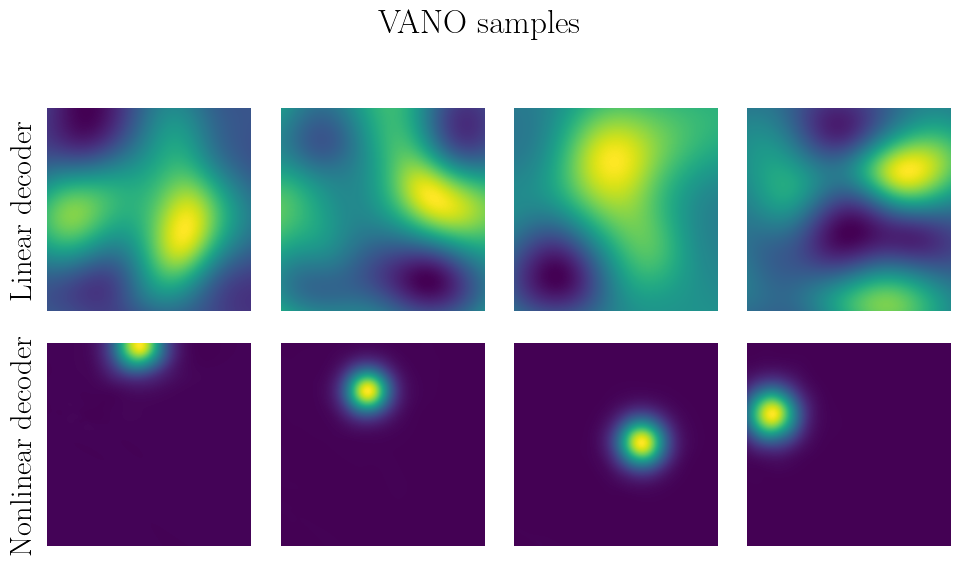

In [12]:

plt.figure(figsize=(10,6))

plt.subplot(2, 4, 1, frameon=False)
plt.imshow(jnp.flipud(samples_1[0,...]))
plt.ylabel('Linear decoder')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 4, 2)
plt.imshow(jnp.flipud(samples_1[1,...]))
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(jnp.flipud(samples_1[2,...]))
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(jnp.flipud(samples_1[3,...]))
plt.axis('off')

plt.subplot(2, 4, 5, frameon=False)
plt.imshow(jnp.flipud(samples_2[0,...]))
plt.ylabel('Nonlinear decoder')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 4, 6)
plt.imshow(jnp.flipud(samples_2[1,...]))
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(jnp.flipud(samples_2[2,...]))
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(jnp.flipud(samples_2[3,...]))
plt.axis('off')

plt.suptitle('VANO samples') # or plt.suptitle('Main title')

plt.tight_layout()
plt.savefig('generated_samples.png', dpi=300)
plt.show()